### Imports and archives

#### Anime.csv

* anime_id - myanimelist.net's unique id identifying an anime.
* name - full name of anime.
* genre - comma separated list of genres for this anime.
* type - movie, TV, OVA, etc.
* episodes - how many episodes in this show. (1 if movie).
* rating - average rating out of 10 for this anime.
* members - number of community members that are in this anime's "group".


#### Rating.csv

* user_id - non identifiable randomly generated user id.
* anime_id - the anime that this user has rated.
* rating - rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import pandas as pd

spark = SparkSession.builder.appName('AnimeAnalysis').getOrCreate()

spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

In [2]:
anime = spark.read.csv('../data/raw/anime.csv', header=True, inferSchema=True)
rating = spark.read.csv('../data/raw/rating.csv', header=True, inferSchema=True)


### Data set Anime

In [4]:
# Mostrar la estructura del DataFrame
anime.printSchema()

# Mostrar los primeros 5 registros
anime.show(5)

# Contar el número de registros en el DataFrame
count = anime.count()
print('El número de registros en el DataFrame ANIME es:', count)

print((anime.count(), len(anime.columns)))



root
 |-- anime_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- type: string (nullable = true)
 |-- episodes: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- members: integer (nullable = true)

+--------+--------------------+--------------------+-----+--------+------+-------+
|anime_id|                name|               genre| type|episodes|rating|members|
+--------+--------------------+--------------------+-----+--------+------+-------+
|   32281|      Kimi no Na wa.|Drama, Romance, S...|Movie|       1|  9.37| 200630|
|    5114|Fullmetal Alchemi...|Action, Adventure...|   TV|      64|  9.26| 793665|
|   28977|            Gintama°|Action, Comedy, H...|   TV|      51|  9.25| 114262|
|    9253|         Steins;Gate|    Sci-Fi, Thriller|   TV|      24|  9.17| 673572|
|    9969|       Gintama&#039;|Action, Comedy, H...|   TV|      51|  9.16| 151266|
+--------+--------------------+--------------------+-----+----

### Data set Rating

In [7]:
rating = rating.withColumnRenamed("anime_id", "anime_id_rating")
rating = rating.withColumnRenamed("rating", "ratingPerUser")

rating.printSchema()

# Mostrar los primeros 5 registros
rating.show(5)

# Contar el número de registros en el DataFrame
count = rating.count()
print('El número de registros en el DataFrame ANIME es:', count)

print((rating.count(), len(rating.columns)))

root
 |-- user_id: integer (nullable = true)
 |-- anime_id_rating: integer (nullable = true)
 |-- ratingPerUser: integer (nullable = true)

+-------+---------------+-------------+
|user_id|anime_id_rating|ratingPerUser|
+-------+---------------+-------------+
|      1|             20|           -1|
|      1|             24|           -1|
|      1|             79|           -1|
|      1|            226|           -1|
|      1|            241|           -1|
+-------+---------------+-------------+
only showing top 5 rows

El número de registros en el DataFrame ANIME es: 7813737
(7813737, 3)


### Join  Anime - Rating

In [8]:
df = anime.alias('anime').join(rating, anime.anime_id == rating.anime_id_rating, 'inner')

In [9]:
df.printSchema()

# Mostrar los primeros 5 registros
df.show(5)

# Contar el número de registros en el DataFrame
count = df.count()
print('El número de registros en el DataFrame ANIME es:', count)

print((df.count(), len(df.columns)))

root
 |-- anime_id: integer (nullable = true)
 |-- name: string (nullable = true)
 |-- genre: string (nullable = true)
 |-- type: string (nullable = true)
 |-- episodes: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- members: integer (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- anime_id_rating: integer (nullable = true)
 |-- ratingPerUser: integer (nullable = true)

+--------+--------------------+--------------------+----+--------+------+-------+-------+---------------+-------------+
|anime_id|                name|               genre|type|episodes|rating|members|user_id|anime_id_rating|ratingPerUser|
+--------+--------------------+--------------------+----+--------+------+-------+-------+---------------+-------------+
|      20|              Naruto|Action, Comedy, M...|  TV|     220|  7.81| 683297|      1|             20|           -1|
|      24|       School Rumble|Comedy, Romance, ...|  TV|      26|  8.06| 178553|      1|             24|       

### Estadisticas

In [10]:
df.select("episodes", "rating", "members", "ratingPerUser").describe().show()

+-------+------------------+------------------+-----------------+------------------+
|summary|          episodes|            rating|          members|     ratingPerUser|
+-------+------------------+------------------+-----------------+------------------+
|  count|           7813727|           7813721|          7813727|           7813727|
|   mean|18.441254670151306|7.6531270735171955|178620.8049811569| 6.144036130261526|
| stddev|35.084983968813674|0.6730287091039874| 188176.417151522|3.7277955168233876|
|    min|                 1|              1.67|               29|                -1|
|    max|           Unknown|               9.5|          1013917|                10|
+-------+------------------+------------------+-----------------+------------------+



In [11]:
null_counts = df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df.columns])
null_counts.show()

+--------+----+-----+----+--------+------+-------+-------+---------------+-------------+
|anime_id|name|genre|type|episodes|rating|members|user_id|anime_id_rating|ratingPerUser|
+--------+----+-----+----+--------+------+-------+-------+---------------+-------------+
|       0|   0|  110|   4|       0|     6|      0|      0|              0|            0|
+--------+----+-----+----+--------+------+-------+-------+---------------+-------------+



In [12]:
df.groupBy('type').count().orderBy('count', ascending=False).show()

+-------+-------+
|   type|  count|
+-------+-------+
|     TV|5283596|
|  Movie|1051998|
|    OVA| 800307|
|Special| 559366|
|    ONA|  91956|
|  Music|  26500|
|   null|      4|
+-------+-------+



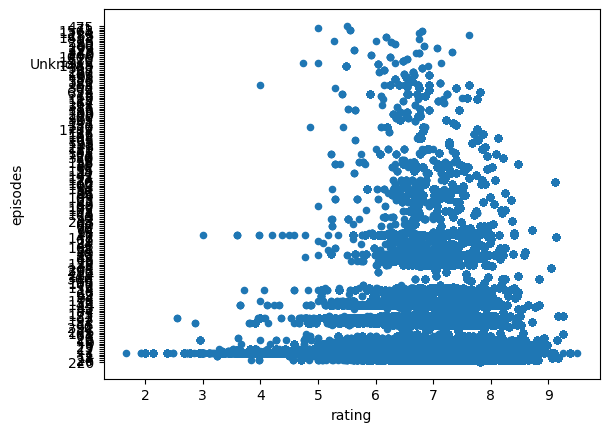

In [13]:
df.select('rating', 'episodes').toPandas().plot(kind='scatter', x='rating', y='episodes')
plt.show()

In [5]:
#anime.write.mode('overwrite').csv('C://anime_cleaned.csv', header=True)
#df.write.format("parquet").save("../data/cleaned/anime_cleaned.parquet")
#anime.write.csv('../data/cleaned/archivo_limpio.csv', header=True, mode='overwrite')
#anime.write.options(header='True', delimiter=',').csv("../data/cleaned/archivo_limpio.csv")
anime.write.csv('C:/Users/Julio/Documents/archivo_limpio.csv')
#anime.write.mode('overwrite').parquet('C:/Users/Julio/Documents/archivo_limpio.parquet')



AnalysisException: path file:/C:/Users/Julio/Documents/archivo_limpio.csv already exists.

### Terminar Spark Session

In [ ]:
# Cerrar SparkSession
spark.stop()